Pruning is an important technique that allows to adapt the trained model to lower resources environment. [wikipedia](https://en.wikipedia.org/wiki/Pruning_(artificial_neural_network))

In this notebook we'll show how to use bayesianization to determine what percentage of neural network weights is required for making prediction (and therefore what percentage can be pruned without decrease in performance).

In [1]:
import os
os.chdir('../..')

In [2]:
import copy
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import torchvision.transforms as TF
from torchmetrics.classification import MulticlassAccuracy
from examples.CIFAR10.models import *
from eXNN.NetBayesianization import BasicBayesianWrapper

In [3]:
# prepare data
_normalize = TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tfm = TF.Compose([TF.ToTensor(), _normalize])
train_ds = CIFAR10(root='./.cache', train=True, download=False, transform=tfm)
test_ds = CIFAR10(root='./.cache', train=False, download=False, transform=tfm)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=True)

In [4]:
train_batch = next(iter(train_dl))
test_batch = next(iter(test_dl))

In [5]:
# download repository https://github.com/Med-AI-Lab/eXNN-task-CIFAR10
# change model_repo to the root of the downloaded repository
model_repo = Path('../eXNN-task-CIFAR10')

In [6]:
# select cuda device
device = torch.device('cpu')

In [7]:
# load models
# full model
svd_model = resnet18(num_classes=10)
decompose_module(svd_model, "channel")
svd_model.load_state_dict(torch.load(model_repo / "ResNet18_SVD_channel_O-100.0_H-0.000100.sd.pt",  map_location=device))
print(f"Number of parameters: {number_of_params(svd_model)}")
svd_model = svd_model.eval()

# pruned model
pruned_model = copy.deepcopy(svd_model)
prune_model(model=pruned_model, energy_threshold=0.9)
print(f"Number of parameters: {number_of_params(pruned_model)}")
pruned_model = pruned_model.eval()

Number of parameters: 12668746
Number of parameters: 7206832


First, let's look at the full model. We are going to make predictions with a Bayesian version of the model with different dropout probability `p`. The value of `p` corresponds to the percentage of weights dropped (pruned).

Text(0, 0.5, 'Accuracy')

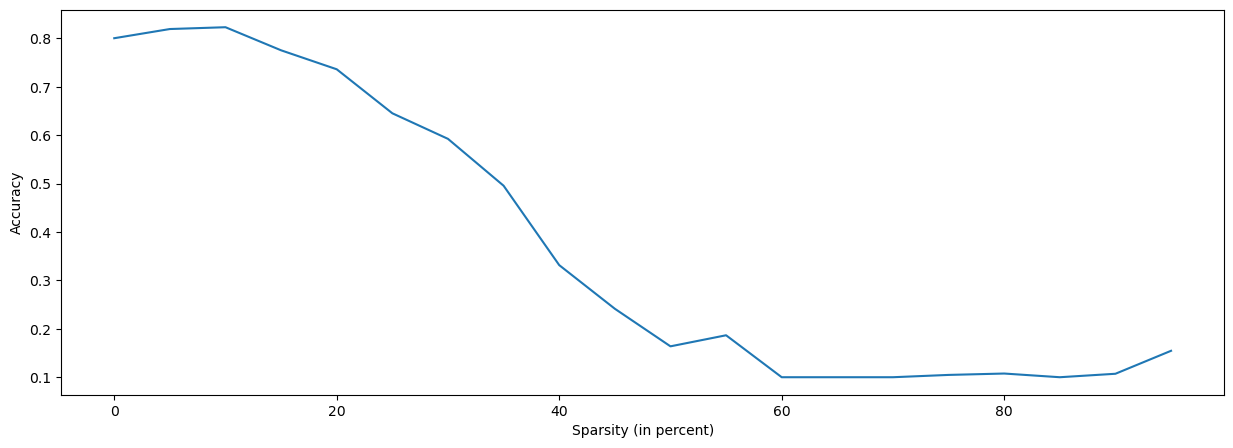

In [8]:
acc_list = []
num_iters = 30
metric = MulticlassAccuracy(num_classes=10)

for p in np.arange(0, 1, 0.05):
    bayes_model = BasicBayesianWrapper(svd_model, 'basic', p, None, None)
    pred = bayes_model.predict(test_batch[0], n_iter=num_iters)
    acc_list.append(metric(pred["mean"], test_batch[1]).item())

plt.figure(figsize = (15, 5))
plt.plot(np.arange(0, 1, 0.05)*100, acc_list)
plt.xlabel("Sparsity (in percent)")
plt.ylabel("Accuracy")

As we can see from the plot, around 25% of the full model weights can be dropped without significant loss in performance.

Now let's do the same with the pruned model.

Text(0, 0.5, 'Accuracy')

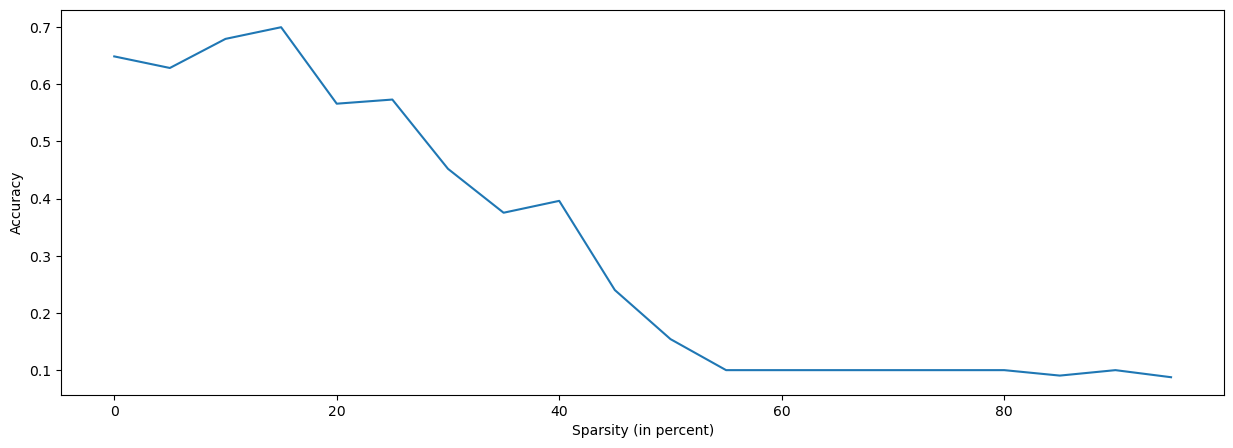

In [9]:
acc_list = []
num_iters = 30
metric = MulticlassAccuracy(num_classes=10)

for p in np.arange(0, 1, 0.05):
    bayes_model = BasicBayesianWrapper(pruned_model, 'basic', p, None, None)
    pred = bayes_model.predict(test_batch[0], n_iter=num_iters)
    acc_list.append(metric(pred["mean"], test_batch[1]).item())

plt.figure(figsize = (15, 5))
plt.plot(np.arange(0, 1, 0.05)*100, acc_list)
plt.xlabel("Sparsity (in percent)")
plt.ylabel("Accuracy")

As we can see from the plot, around 20% of the pruned model weights can be dropped without significant loss in performance.